In [1]:
!nnUNet_predict -i nnUNet/nnunet/nnUNet_raw_data_base/nnUNet_raw_data/Task107_PR2/imagesTs -o nnUNet/nnunet/nnUNet_Prediction_Results/Task107_PR2/ -t 107 -tr nnUNetTrainerV2_Loss_Dice_Soft -m 2d --save_npz --overwrite_existing


Please cite the following paper when using nnUNet:
Fabian Isensee, Paul F. Jäger, Simon A. A. Kohl, Jens Petersen, Klaus H. Maier-Hein "Automated Design of Deep Learning Methods for Biomedical Image Segmentation" arXiv preprint arXiv:1904.08128 (2020).
If you have questions or suggestions, feel free to open an issue at https://github.com/MIC-DKFZ/nnUNet

using model stored in  /home/mzukovec/Documents/Faks/Semester 3/AMS/nnUNet/nnunet/nnUNet_trained_models/nnUNet/2d/Task107_PR2/nnUNetTrainerV2_Loss_Dice_Soft__nnUNetPlansv2.1
This model expects 1 input modalities for each image
Found 7 unique case ids, here are some examples: ['case49' 'case49' 'case51' 'case53' 'case49' 'case52' 'case52']
If they don't look right, make sure to double check your filenames. They must end with _0000.nii.gz etc
emptying cuda cache
loading parameters for folds, None
folds is None so we will automatically look for output folders (not using 'all'!)
found the following folds:  ['/home/mzukovec/Documents/Faks/

In [2]:
#!nnUNet_predict -i nnUNet/nnunet/nnUNet_raw_data_base/nnUNet_raw_data/Task107_PR2/testing -o nnUNet/nnunet/nnUNet_Prediction_Results/Task107_PR2 -t 105 -tr nnUNetTrainerV2_Loss_Dice_Soft -m 2d --save_npz --overwrite_existing

In [17]:
%matplotlib notebook
import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt
import os

In [18]:
def getAverage(path):
    paths = os.listdir(path)
    tmp = []
    for pt in paths:
        if 'task02' in pt:
            tmp.append(pt)
    tmp2 = sitk.ReadImage(os.path.join(path, tmp[0]))
    for i in range(1, len(tmp)):
        tmp2 += sitk.ReadImage(os.path.join(path, tmp[i]))
    return sitk.GetArrayFromImage(tmp2)

<IPython.core.display.Javascript object>


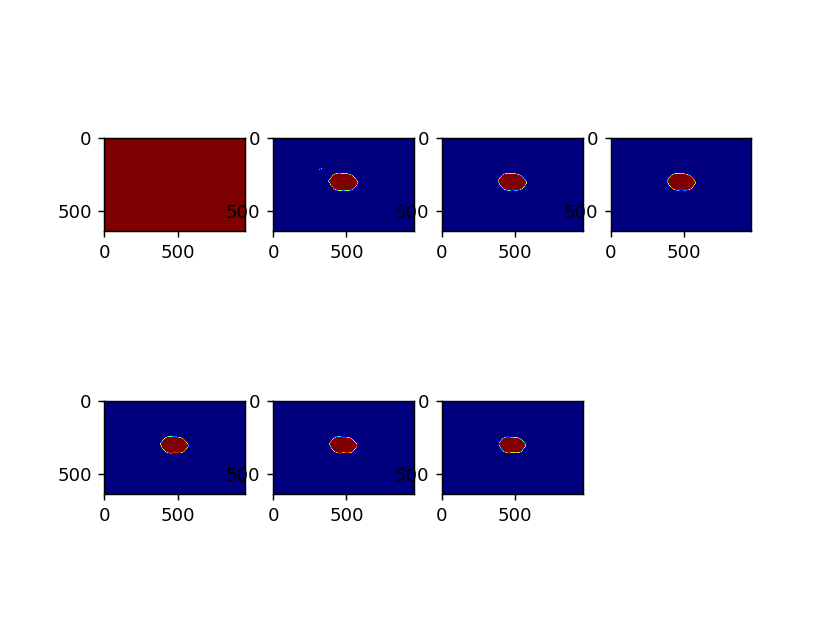

In [19]:
data = np.load('/home/mzukovec/Documents/Faks/Semester 3/AMS/nnUNet/nnunet/nnUNet_Prediction_Results/Task107_PR2/case51.npz')
ground_truth = getAverage('Data/validation_data_v2/prostate/Validation/case51')
plt.figure()
for i in range(7):
    plt.subplot(2,4,i+1)
    plt.imshow(np.array(data['softmax'][i,:,:]>0.5, dtype=np.float32), cmap='jet')
plt.show()

<IPython.core.display.Javascript object>


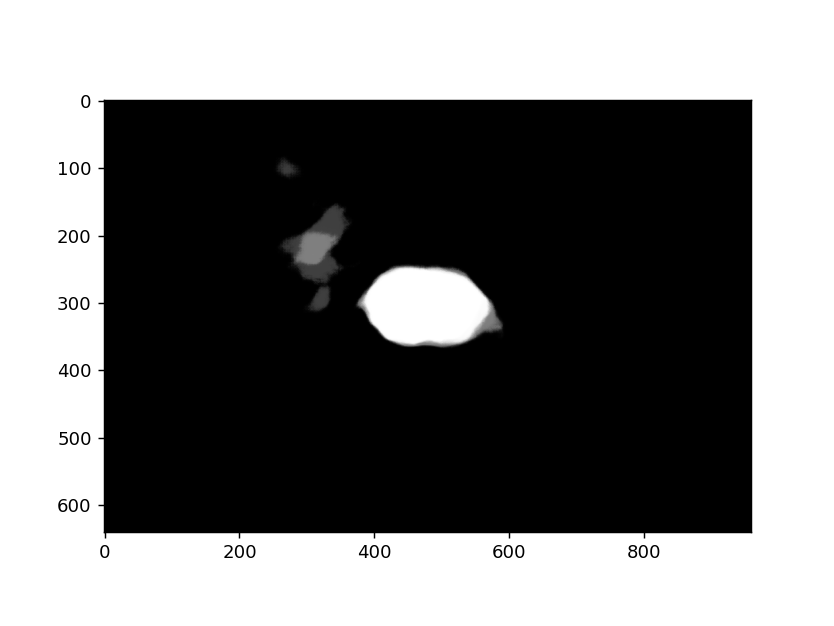

In [20]:
plt.figure()
plt.imshow(np.array(data['softmax'][2,:,:], dtype=np.float32), cmap='gray')
plt.show()

In [31]:
plt.figure()
plt.subplot(1,2,1)
plt.imshow(ground_truth[0,:,:], cmap='jet')
plt.subplot(1,2,2)
plt.imshow((np.array(data['softmax'][1:,:,:], dtype=np.float32)>0.5).sum(axis=0), cmap='jet')
plt.show()

<IPython.core.display.Javascript object>

IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

In [22]:
def dice(result, reference):
    result = np.atleast_1d(result.astype(np.bool))
    reference = np.atleast_1d(reference.astype(np.bool))
    intersection = np.count_nonzero(result & reference)
    size_i1 = np.count_nonzero(result)
    size_i2 = np.count_nonzero(reference)

    try:
        dc = 2. * intersection / float(size_i1 + size_i2)
    except ZeroDivisionError:
        dc = 0.0
    return dc

def total_dice(ground_truth, predicted):
    prob_threshold = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
    tmp = 0
    for idx, th in enumerate(prob_threshold):
        predicted_thr = (predicted > th).astype(np.uint8)
        ground_truth_thr = (ground_truth > idx).astype(np.uint8)
        tmp += dice(predicted_thr, ground_truth_thr)
    return tmp/9.0

In [23]:
cases = os.listdir('/home/mzukovec/Documents/Faks/Semester 3/AMS/Data/validation_data_v2/prostate/Validation')
ground_truths = []
predictions = []

for case in cases:
    ground_truths.append(getAverage('Data/validation_data_v2/prostate/Validation/' + case))
    data = np.load('/home/mzukovec/Documents/Faks/Semester 3/AMS/nnUNet/nnunet/nnUNet_Prediction_Results/Task107_PR2/'+case+'.npz')
    predictions.append((np.array(data['softmax'][1:,:,:], dtype=np.float32)>0.5).sum(axis=0))

<IPython.core.display.Javascript object>


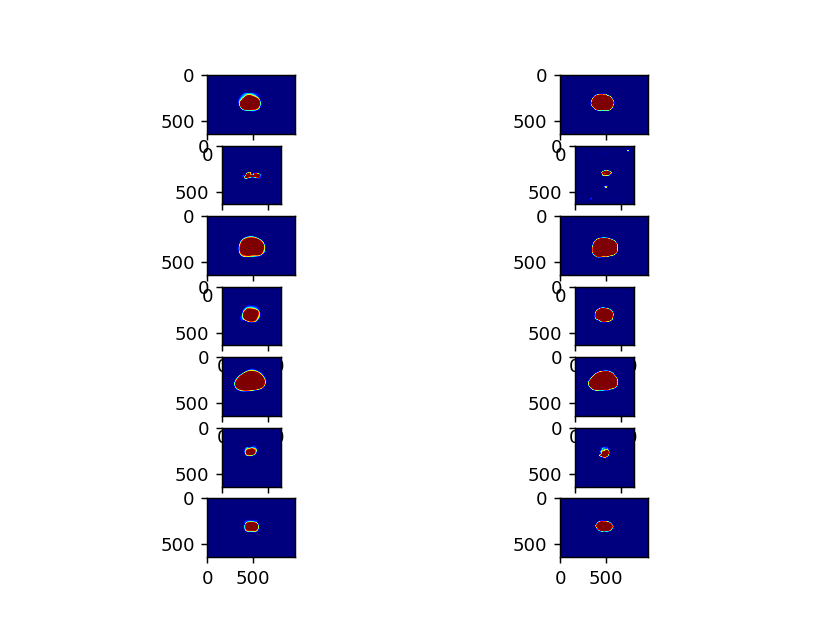

In [24]:
dice_score = []
for i in range(len(ground_truths)):
    dice_score.append(total_dice(ground_truths[i], predictions[i]))

idx = 1
plt.figure()
for i in range(len(ground_truths)):
    plt.subplot(len(ground_truths), 2, idx)
    idx += 1
    plt.imshow(np.array(ground_truths[i][0,:,:], dtype=np.float32), cmap='jet')
    plt.subplot(len(ground_truths), 2, idx)
    idx += 1
    plt.imshow(np.array(predictions[i], dtype=np.float32), cmap='jet')
plt.show()

In [25]:
print('Dice for validation images: ', np.mean(dice_score))

Dice for validation images:  0.511637234386855


In [26]:
dice_score

[0.6046575825971572,
 0.03463942217731372,
 0.637409799014043,
 0.601814840209764,
 0.6437325520267168,
 0.48987223791434253,
 0.5693342067686478]

In [27]:
def dice(result, reference):
    result = np.atleast_1d(result.astype(np.bool))
    reference = np.atleast_1d(reference.astype(np.bool))
    intersection = np.count_nonzero(result & reference)
    size_i1 = np.count_nonzero(result)
    size_i2 = np.count_nonzero(reference)

    try:
        dc = 2. * intersection / float(size_i1 + size_i2)
    except ZeroDivisionError:
        dc = 0.0
    return dc

def total_dice2(ground_truth, predicted):
    prob_threshold = [0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
    tmp = []
    for idx, th in enumerate(prob_threshold):
        predicted_thr = (predicted[idx+1, :, :] > th).astype(np.uint8)
        ground_truth_thr = (ground_truth > idx).astype(np.uint8)
        tmp.append(dice(predicted_thr, ground_truth_thr))
    return tmp

In [28]:
data = np.load('/home/mzukovec/Documents/Faks/Semester 3/AMS/nnUNet/nnunet/nnUNet_Prediction_Results/Task106_PR1/case50.npz')
ground_truth = getAverage('Data/validation_data_v2/prostate/Validation/case50')[0,:,:]
predicted= (np.array(data['softmax'], dtype=np.float32))

total_dice2(ground_truth, predicted)

[0.6710952137625618, 0.0, 0.0, 0.0, 0.0, 0.0]

<IPython.core.display.Javascript object>


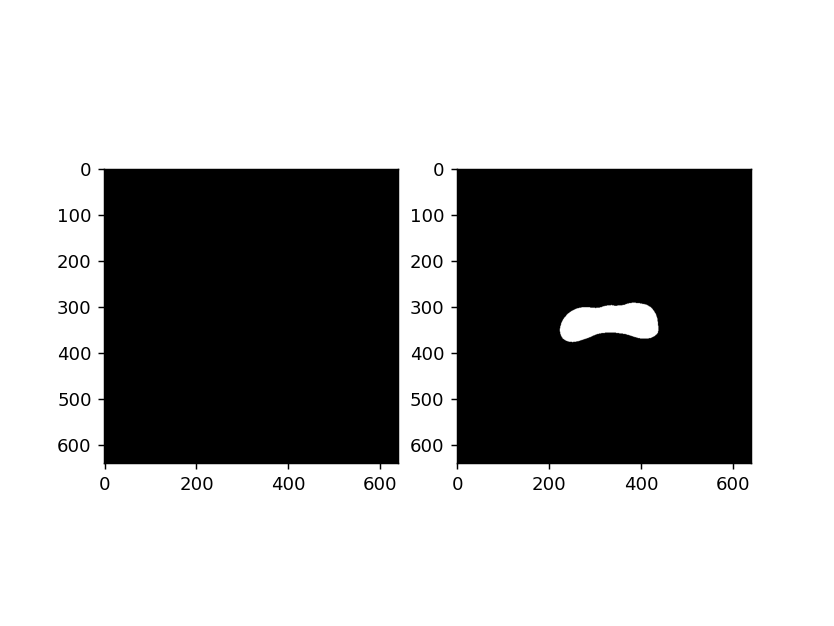

In [29]:
plt.figure()
plt.subplot(1,2,1)
plt.imshow(ground_truth>=3, cmap='gray')
plt.subplot(1,2,2)
plt.imshow(predicted[3,:,:]>0.5, cmap='gray')
plt.show()

In [30]:
ground_truths[0].shape

(1, 640, 960)